# Word2Vec Algorithm

This is an implementation of the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. 
I'm adapting code from a course in Udacity to our problem. The original code is here: https://github.com/udacity/deep-learning-v2-pytorch/tree/master/word2vec-embeddings 

In [1]:
from project_helper import TweetData
from skipgram import get_batches, SkipGramNeg, NegativeSamplingLoss, subsampling
from skipgram import cosine_similarity, cosine_similarity_sample, plot_similar_words
import numpy as np
import random

import torch
from torch import nn
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
data = TweetData('data/opt/trump_archive_db_1910.csv')

In [3]:
# get list of words
words = data.words
print(words[:30])

['while', 'the', 'do', 'nothing', 'democrats', 'fail', 'the', 'american', 'people', 'and', 'continue', 'the', 'impeachment', 'scam', 'my', 'administration', 'will', 'continue', 'to', 'deliver', 'real', 'results', 'as', 'seen', 'over', 'the', 'past', 'month', 'below', 'the']


In [4]:
print("Total words in Trump's tweets: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in Trump's tweets: 395944
Unique words: 4583


In [3]:
# These are two dictionaries to convert words to integers and back again (integers to words). 
# The integers are assigned in descending frequency order, so the most frequent word ("the") 
# is given the integer 0 and the next most frequent is 1, etc. 

vocab_to_int, int_to_vocab = data.vocab_to_int, data.int_to_vocab
int_words = data.int_words

print(int_words[:30])

[253, 0, 47, 140, 75, 1451, 0, 104, 33, 2, 402, 0, 686, 713, 32, 279, 10, 402, 1, 1381, 306, 559, 39, 505, 107, 0, 698, 1061, 3512, 0]


## Training


In [22]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Get our noise distribution
threshold = 1e-4 #lowered threshold as used in Word2Vec algorithm since we have smaller sample
freqs, train_words = subsampling(threshold, int_words)
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

#original is 5, skipgram paper suggests up to 20 for small data sets
N_negative_sampling = 7

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using Negative Sampling Loss as our loss function
criterion = NegativeSamplingLoss() 

# Choosing optimzier
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train for some number of epochs
print_every = 200
steps = 0
epochs = 20


for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], N_negative_sampling)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/20
Loss:  8.415261268615723
want | by, k, benefits, narrative, turn
like | crossings, meaningful, steel, leak, trillions
your | smooth, charged, mentally, hoax, holes
again | wont, lots, referred, three, israel
do | catastrophe, qualified, roaring, long, willing
very | win, players, negotiating, guilty, looking
president | sharpton, speaker, button, renegotiate, picked
fake | take, abuse, powers, davidson, names
clue | party, misrepresents, greg, speed, source
defense | destroy, is, families, guy, his
terrorism | recognized, consumer, british, producing, guard
death | clear, service, controversial, judges, dershowitz
victims | institute, jeffress, darrell, blessed, that
offers | again, heroes, thats, referred, storms
reserve | mcgahn, generation, payments, matter, weve
closely | desperately, staying, respect, pundit, airports
...

Epoch: 2/20
Loss:  4.909303188323975
was | old, from, create, unable, insurance
you | their, that, europe, administration, a
t | this, all, agents, 

me | tickets, reno, las, bull, nevada
and | of, the, are, for, we
as | today, down, tillerson, architectural, our
democrats | dems, only, end, republicans, radical
reserve | federal, raising, countries, monetary, germany
officials | local, flooding, storm, preparing, heed
award | dunn, largely, restaurant, mar, club
debt | same, dream, cost, apart, us
involved | situation, one, definitely, fine, even
eric | private, schneiderman, about, writers, lets
within | number, rejected, just, anything, numerous
standing | secretly, peace, eight, wars, modern
...

Epoch: 17/20
Loss:  2.489556074142456
at | m, p, on, golf, et
just | a, really, are, with, leaving
who | actually, of, poorly, would, have
very | the, france, exciting, today, is
president | xi, putin, spoken, with, have
so | i, all, if, minute, foolish
not | that, is, anchor, belittle, rosie
are | and, their, in, all, we
disgusting | false, fake, badly, get, say
signing | crippled, next, congratulations, over, angeles
negotiations | on

In [ ]:
#If you wanna save the model
#torch.save(model,'models/trump_rnn_1910.net')

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.
Wiki on T-SNE, a bit complicated! https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [7]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

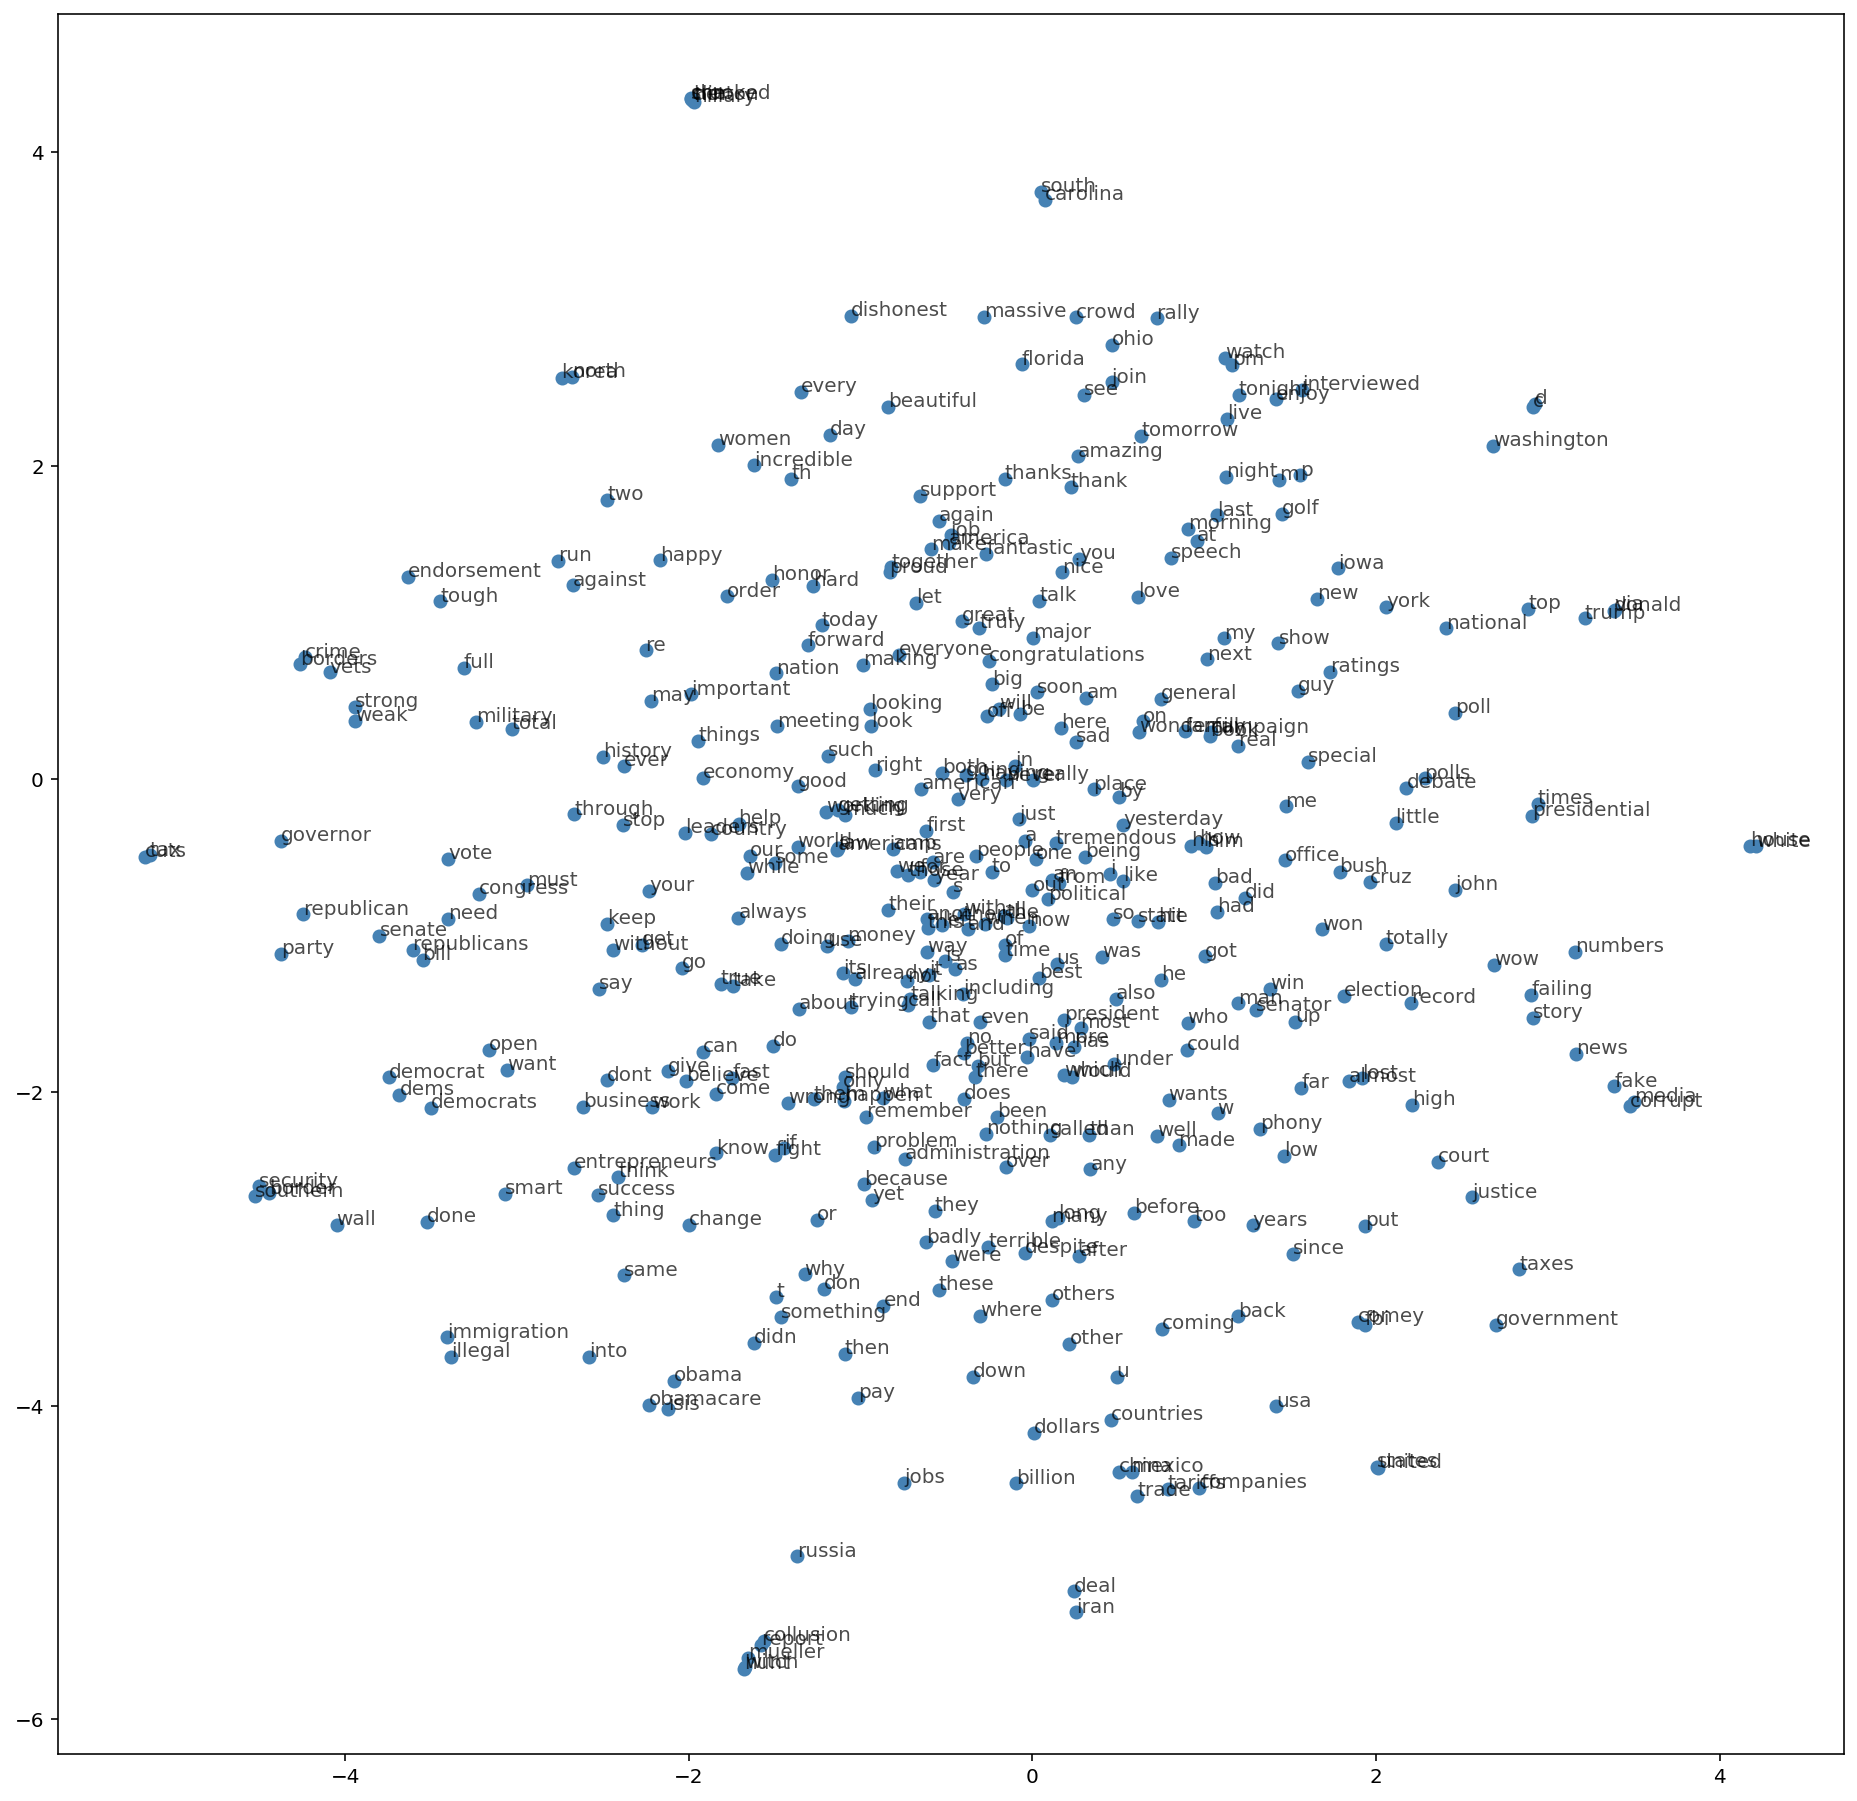

In [24]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [4]:
# If you wanna load a pre-trained model
model = torch.load('models/trump_rnn_1911.net')
keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign', 'fed', 'china', 'mexico', 'tariffs','tax']
embeddings = model.in_embed.weight.to('cpu').data.numpy()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

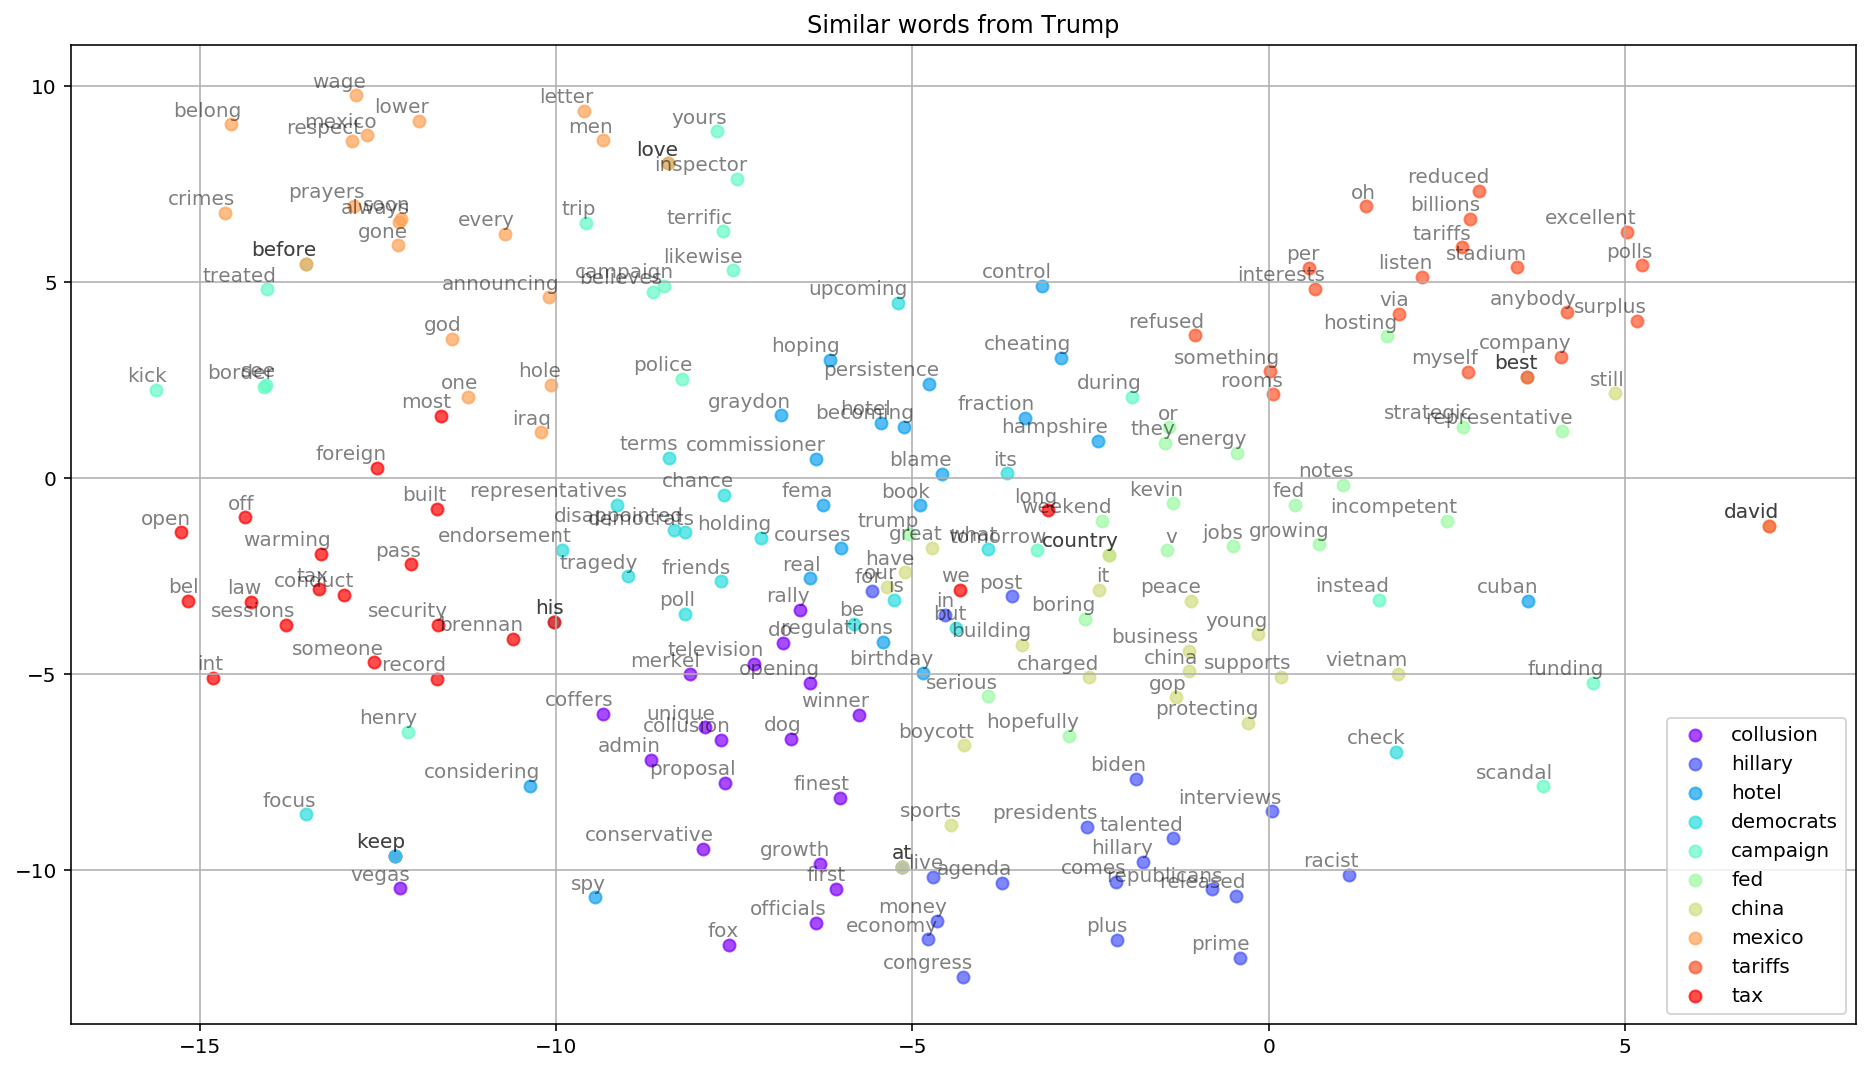

In [5]:
plot_similar_words(keys, model, vocab_to_int, int_to_vocab, num=20, file=None)